# Проект "Исследование воронки продаж игровых оффлайн квестов"

**Описание исследования:** Есть данные по результатам продаж игровых оффлайн квестов. Необходимо найти слабые места в воронке продаж, где теряются потенциальные клиенты.

**Задача исследования:** Построить воронку, которая показывала бы в динамике по неделям и месяцам, сколько клиентов посещает сайт, и какая доля из них регистрируется на нём, подаёт заявку на игру, по факту приходит на неё.

**Используемые инструменты:** PostgreSQL (pgAdmin4, командная строка, SQL Shell (psql): создание базы данных, загрузка данных из .csv файлов), SQL (создание сводной таблицы: объединие таблиц БД; использование условной конструкции CASE, функции DATE_PART), Python (pandas (работа с типами данных, создание таблиц, группировка), seaborn, matplotlib (визуалиция данных: построение воронки продаж))

**Результат:** Определены слабые места в воронке продаж, предложены потенциальные точки роста продукта.

Датасеты взяты при прохождении курса Тинькофф "Анализ данных в индустрии 2023 (вольные слушатели)".

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных." data-toc-modified-id="Подготовка-данных.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных.</a></span></li><li><span><a href="#Исследование-данных." data-toc-modified-id="Исследование-данных.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование данных.</a></span></li><li><span><a href="#Вывод." data-toc-modified-id="Вывод.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Вывод.</a></span></li></ul></div>

## Подготовка данных.

Загрузим необходимые библиотеки.

In [1]:
import psycopg2
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

Установим соединение с локальной базой данных. До этого в pgAdmin4 была создана локальная база данных quests, в которую через SQL Shell (psql) загружены данные из .csv файлов.

In [2]:
conn = psycopg2.connect(user = "postgres",
                          password = "sql24",
                          host = "localhost",
                          port = "5432",
                          database = "quests")

cur = conn.cursor()

Схема базы данных квестов.

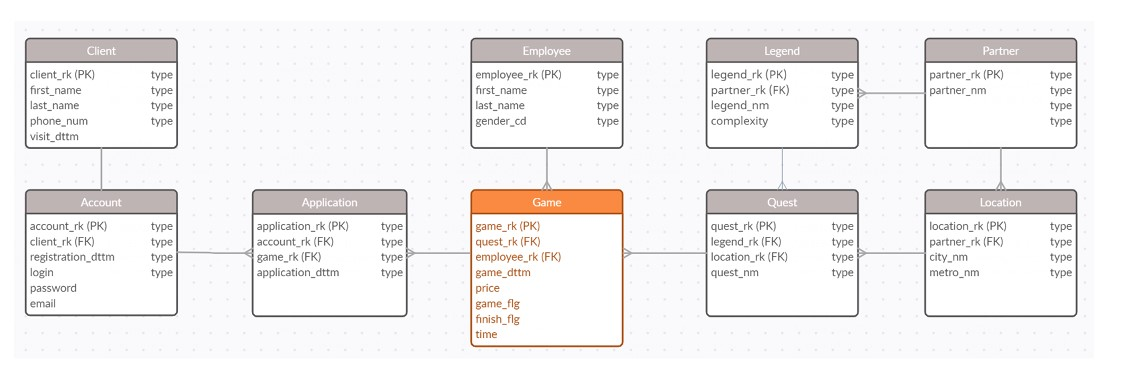

При формировании сводного датасета **для каждого клиента, зарегистрировшегося на сайте игровых квестов и подавшего одну или более заявок на игру, учитывается только одна заявка на игру, а также одна игра, если такая игра состоялась**. В противном случае данные будут искажены (например, когда один клиент оставляет 2 (две) и более заявок на игру, то есть конверсия будет искусственно завышена), и, как следствие, окажут влияние на расчёт конверсии и выводы по итогам исследования.

**Сформируем общую таблицу по каждому клиенту (пользователю): дата, месяц и неделя последнего посещения сайта, флаг регистрации на сайте (0 - не зарегистрировался, 1 - зарегистрировался), флаг создания заявки на игру, флаг состоявшейся игры, флаг прохождения игры.**

In [3]:
result = pd.read_sql('''

                     SELECT cl.client_rk,
                     cl.visit_dttm::DATE AS visit_dt,

                     DATE_TRUNC('month', cl.visit_dttm)::DATE AS visit_mth,
                     DATE_TRUNC('week', cl.visit_dttm)::DATE AS visit_week,

                     MAX(CASE WHEN ac.registration_dttm::DATE is not null THEN 1 ELSE 0 END) AS reg_flg,
                     MAX(CASE WHEN ap.application_dttm::DATE is not null THEN 1 ELSE 0 END) AS appl_flg,
                     MAX(CASE WHEN g.game_flg = 1 THEN 1 ELSE 0 END) AS game_flg,
                     MAX(CASE WHEN g.finish_flg = 1 THEN 1 ELSE 0 END) AS finish_flg

                     FROM client AS cl
                     LEFT JOIN account AS ac
                     ON cl.client_rk = ac.client_rk
                     LEFT JOIN application AS ap
                     ON ac.account_rk = ap.account_rk
                     LEFT JOIN game AS g
                     ON g.game_rk = ap.game_rk

                     GROUP BY 1, 2, 3, 4;

                    ''', conn)

Выведем первые 5 строк общей таблицы и сведения о ней.

In [4]:
result.head()

,client_rk,visit_dt,visit_mth,visit_week,reg_flg,appl_flg,game_flg,finish_flg
0,1666,2022-11-26,2022-11-01,2022-11-21,0,0,0,0
1,1431,2022-10-07,2022-10-01,2022-10-03,0,0,0,0
2,2641,2022-09-19,2022-09-01,2022-09-19,0,0,0,0
3,4039,2022-11-29,2022-11-01,2022-11-28,0,0,0,0
4,1810,2022-12-01,2022-12-01,2022-11-28,0,0,0,0


In [5]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   client_rk   4096 non-null   int64 
 1   visit_dt    4096 non-null   object
 2   visit_mth   4096 non-null   object
 3   visit_week  4096 non-null   object
 4   reg_flg     4096 non-null   int64 
 5   appl_flg    4096 non-null   int64 
 6   game_flg    4096 non-null   int64 
 7   finish_flg  4096 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 256.1+ KB


Данные в столбцах с датами приведём к нужному типу (столбцы: visit_dt, visit_mth, visit_week).

In [6]:
result.visit_dt = pd.to_datetime(result.visit_dt)
result.visit_mth = pd.to_datetime(result.visit_mth)
result.visit_week = pd.to_datetime(result.visit_week)

Сразу проверим, как изменение типов данных.

In [7]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_rk   4096 non-null   int64         
 1   visit_dt    4096 non-null   datetime64[ns]
 2   visit_mth   4096 non-null   datetime64[ns]
 3   visit_week  4096 non-null   datetime64[ns]
 4   reg_flg     4096 non-null   int64         
 5   appl_flg    4096 non-null   int64         
 6   game_flg    4096 non-null   int64         
 7   finish_flg  4096 non-null   int64         
dtypes: datetime64[ns](3), int64(5)
memory usage: 256.1 KB


Проверим полноту представленных данных (за сколько дней в каждом месяце есть сведения).

In [8]:
group_month = (result
                .groupby('visit_mth')
                .agg({'visit_dt':'nunique'})
                .reset_index()
               )
group_month

,visit_mth,visit_dt
0,2022-09-01,30
1,2022-10-01,31
2,2022-11-01,30
3,2022-12-01,31
4,2023-01-01,31
5,2023-02-01,2


Получается, что за февраль у нас неполные данные (всего за 2 дня вместо 28). Будем учитывать данное обстоятельство при исследовании данных.

##  Исследование данных.

Создадим агрегированные таблицы по неделям и по месяцам для визуализации динамики по неделям и месяцам, и формирования воронки продаж. 

In [9]:
result_week = (result
                .groupby('visit_week')
                .agg({'client_rk':'nunique', 'reg_flg':'sum', 'appl_flg':'sum', 'game_flg':'sum', 'finish_flg':'sum'})
                .reset_index()
               )

In [10]:
result_week.head()

,visit_week,client_rk,reg_flg,appl_flg,game_flg,finish_flg
0,2022-08-29,111,32,7,5,2
1,2022-09-05,184,31,6,5,2
2,2022-09-12,167,43,16,8,5
3,2022-09-19,181,45,12,11,9
4,2022-09-26,195,59,17,17,9


In [11]:
result_month = (result
                .groupby('visit_mth')
                .agg({'client_rk':'nunique', 'reg_flg':'sum', 'appl_flg':'sum', 'game_flg':'sum', 'finish_flg':'sum'})
                .reset_index()
               )

In [12]:
result_month.head()

,visit_mth,client_rk,reg_flg,appl_flg,game_flg,finish_flg
0,2022-09-01,778,190,51,39,23
1,2022-10-01,843,217,65,56,30
2,2022-11-01,786,200,56,50,34
3,2022-12-01,805,196,57,33,19
4,2023-01-01,852,213,64,20,14


Посмотрим какое количество клиентов (в том числе потенциальных) посещали сайт по продаже оффлайн квестов.

In [13]:
def create_lineplot(data, column_x, values, title):
    """Функция для построения линейных графиков"""
    plt.figure(figsize=(13, 5))
    ax = sns.lineplot(data=data, x=column_x, y='client_rk')
    ax.set(xticks=values)
    plt.suptitle(title, fontsize=15, fontweight='bold')
    plt.ylabel('', fontsize=10)
    plt.xlabel(' ', fontsize=10)
    plt.xticks(rotation=45)
    plt.grid(True)

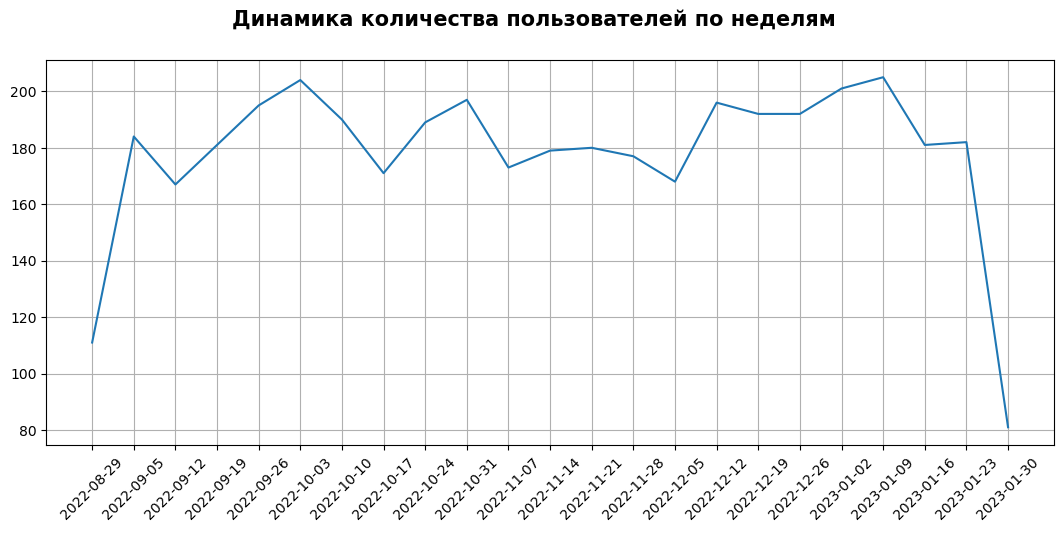

In [14]:
create_lineplot(result_week, 'visit_week', result_week.visit_week.values, 'Динамика количества пользователей по неделям')

Максимальное количество пользователей, посетивших сайт, зафиксировано на отдельных неделях в октябре (2022-09-26) и в январе (2023-01-09) (более 200 человек), минимальное - на отдельных неделях в сентябре (2022-08-29) (около 110 пользователей в начале старта кампании по продаже оффлайн квестов) и в феврале (2023-01-30) (чуть более 80 пользователей).

Теперь посмотрим на такую же динамику по месяцам. При этом, не будем учитывать февраль, так как за этот месяц у нас неполные данные.

In [15]:
# строить линейный график будет по срезу таблицы, агригированной по месяцам 
result_5_months = result_month.query('visit_mth != "2023-02-01 00:00:00"')

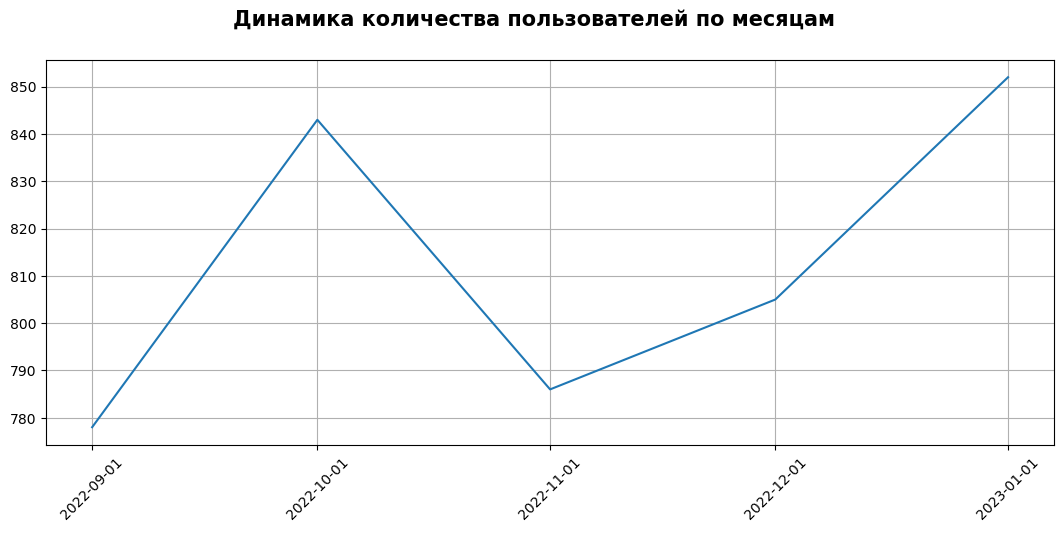

In [16]:
create_lineplot(result_5_months, 'visit_mth', result_5_months.visit_mth.values, 'Динамика количества пользователей по месяцам')

Максимальное количество пользователей зафиксировано в январе (более 850 потенциальных клиентов) и  в октябре (более 840 пользователей). Минимальное количество - в сентябре (менее 780 пользователей) и в ноябре (менее 790 пользователей).

Перейдём к построению воронок продаж, чтобы понимать на каких этапах происходит проседание конверсии. Динамику показателя также будем рассматривать по неделям и по месяцам. Для этого сначала подготовим данные.

Конверсию каждого этапа будем считать от предыдущего.

Шаги воронки продаж:
- client_rk	- посещение сайта;
- reg_flg - регистрация на сайте;
- appl_flg - подача заявки на игру;
- game_flg - прошедшая игра;
- finish_flg - пройденная игра.

In [17]:
def create_funnel_table (base_table):
    """Функция для создания таблицы воронки продаж"""
    result = base_table
    result['reg_ratio'] = round(result['reg_flg']/result['client_rk']*100, 2)
    result['appl_ratio'] = round(result['appl_flg']/result['reg_flg']*100, 2)
    result['game_ratio'] = round(result['game_flg']/result['appl_flg']*100, 2)
    result['finish_ratio'] = round(result['finish_flg']/result['game_flg']*100, 2)
    return result

In [18]:
result_week_CR = create_funnel_table (result_week)
result_week_CR.head()

,visit_week,client_rk,reg_flg,appl_flg,game_flg,finish_flg,reg_ratio,appl_ratio,game_ratio,finish_ratio
0,2022-08-29,111,32,7,5,2,28.83,21.88,71.43,40.00
1,2022-09-05,184,31,6,5,2,16.85,19.35,83.33,40.00
2,2022-09-12,167,43,16,8,5,25.75,37.21,50.00,62.50
3,2022-09-19,181,45,12,11,9,24.86,26.67,91.67,81.82
4,2022-09-26,195,59,17,17,9,30.26,28.81,100.00,52.94


In [19]:
result_month_CR = create_funnel_table (result_5_months)
result_month_CR

,visit_mth,client_rk,reg_flg,appl_flg,game_flg,finish_flg,reg_ratio,appl_ratio,game_ratio,finish_ratio
0,2022-09-01,778,190,51,39,23,24.42,26.84,76.47,58.97
1,2022-10-01,843,217,65,56,30,25.74,29.95,86.15,53.57
2,2022-11-01,786,200,56,50,34,25.45,28.00,89.29,68.00
3,2022-12-01,805,196,57,33,19,24.35,29.08,57.89,57.58
4,2023-01-01,852,213,64,20,14,25.00,30.05,31.25,70.00


Теперь визуализируем динамику конверсии.

In [20]:
def create_lineplots(data, column_x, values, title):
    """Функция для построения двух графиков динамики конверсии по неделям и по месяцам"""
    
    fig, ax = plt.subplots()
    ax1 = sns.lineplot(data=data, x=column_x, y='reg_ratio', label='регистрация')
    ax2 = sns.lineplot(data=data, x=column_x, y='appl_ratio', label='заявка')
    ax3 = sns.lineplot(data=data, x=column_x, y='game_ratio', label='прошедшая игра')
    ax4 = sns.lineplot(data=data, x=column_x, y='finish_ratio', label='пройденная игра')
    ax.set(xticks=values)
    fig.suptitle(title, fontsize=15, fontweight='bold')
    plt.ylabel('', fontsize=10)
    plt.xlabel(' ', fontsize=10)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.set_size_inches(10, 5, forward=True)
    plt.show()

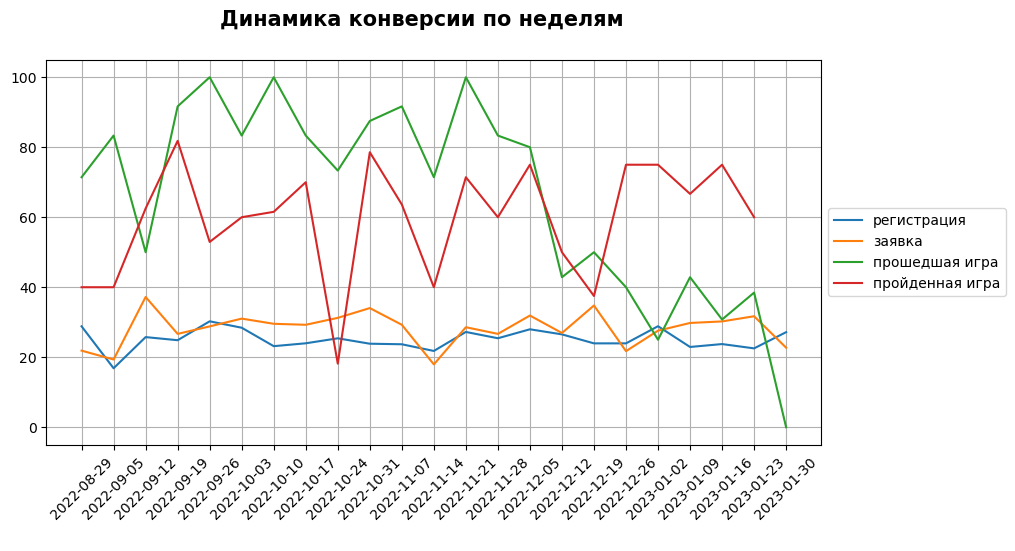

In [21]:
create_lineplots(result_week_CR, 'visit_week', result_week_CR.visit_week, 'Динамика конверсии по неделям')

На графике видно, что:
   - **значения конверсии на этапах регистрации и оформления заявок на игры находятся примерно в одном диапазоне от 20% до 40%** без учёта двух снижений ниже уровня в 20% (начало учебного года и середина ноября);
   - при этом, **значения конверсии на этапе состоявшихся и пройденных игр находятся в основном в диапазоне от 40% до 100%**, за исключением снижений примерно до 50% в первой декаде сентября (начало учебного года), а также с начала декабря до конца января (новогодние праздники, зимняя сессия у студентов).

Теперь перейдём к визуализации данных в разрезе месяцев.

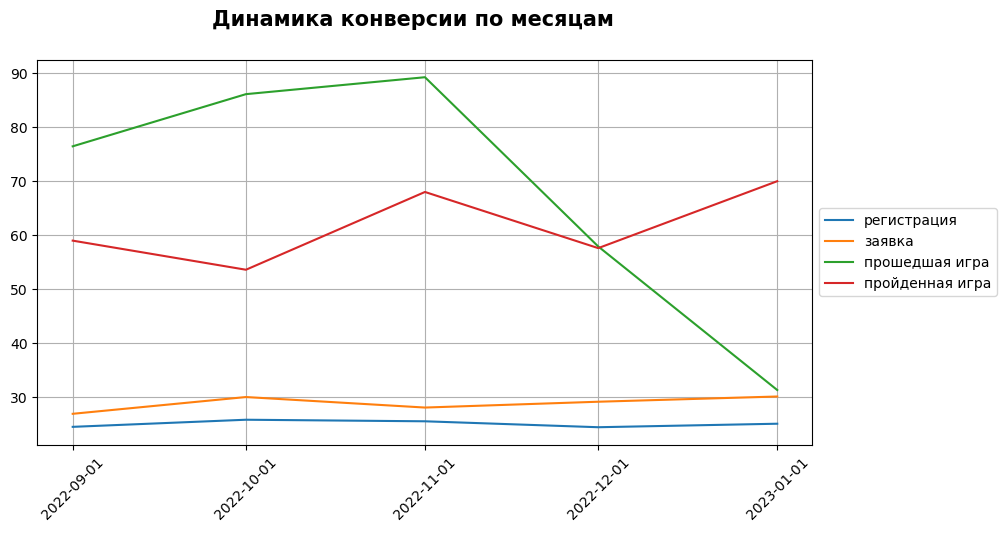

In [22]:
create_lineplots(result_month_CR, 'visit_mth', result_month_CR.visit_mth, 'Динамика конверсии по месяцам')

Как видно на графике:
   - **значения конверсии на этапах регистрации и оформления заявок на игры находятся примерно в одном диапазоне от 20% до 30%**;
   - при этом, **значения конверсии на этапе состоявшихся игр находятся в основном в диапазоне от 75% в сентябре до практически 90% в октябре-ноябре, в декабре-январе значение конверсии состоявшихся игр показывает значительное снижение от 57,9% в декабре до 31,32% в январе**;
   - **значения конверии на этапе пройденных игр составляет от 50% до 70%** (самая низкая конверсия в октябре (чуть более 50%), максимальные значения - в ноябре и январе - почти 70%).

In [23]:
cur.close()
conn.close()

##  Вывод.

**В результате проведённого анализа данных прохождения воронки продаж оффлайн квестов**, установлено, что **значительное снижение значений конверсии на всех этапах** (регистрация на сайте, оформление завяки на игру, состоявшаяся игра, пройденная игра) **связано с определёнными временными периодами** (начало учебного года у студентов и школьников, которые, вероятнее всего, являются основной целевой аудиторией, подготовка и проведение новогодних праздников, зимняя сессия у студентов).

Следовательно, **возможны следующие точки роста продукта**:

- **предложение скидок** (например, разовые скидки или накопительные скидки на картах) **на проведение игр в первой декаде сентября, в декабре и в январе**, когда происходит снижение значений конверсии (для перехода клиентов на этап состоявшихся игр);

- **проведение различных акций, розыгрышей** как среди зарегистрированных клиентов, так и среди клиентов, оставивших заявки на игры и (или) ранее принявших участие в играх;

- **награждение лучших команд по итогам прохождения квестов на основе составления рейтинга** за определённый период;

- **рассылка зарегистрированным клиентам новостной информации** (например, график проведения игр на следующий период, проведение акций, розыгрышей, соревнований между командами, обновление ассортимента проводимых игр, добавление новых моментов в существующие игры, появление новых локаций, а также их модернизация) (для перехода клиентов на этап оформления заявки);

- **проведение анализа состояния сайта продукта** (например, клиенты могут не перейти на этап регистрации из-за необходимости заполнения анкеты со множеством полей (оставить в анкете только действительно необходимые пункты), также клиенты не могут легко и быстро найти интересующую информацию о квестах (цены, описание, визуальное сопровождение (фото, видео локаций, а также прохождения квестов), график проведения игр)) (для перехода клиентов на этапы регистрации и (или) оформления заявки);

- **проведение анализа состояния мобильной версии сайта продукта** (например, сайт не адаптирован полностью под мобильные устройства) (для перехода клиентов на этапы регистрации и (или) оформления заявки).


Кроме того, для разработки эффективных предложений в целях увеличения значений конверсии продаж оффлайн квестов представляется целесообразным получение обратной связи от клиентов, не перешедших на следующий этап воронки продаж (например, проведение опросов посредством направления писем на электронные адреса зарегистрированных клиентов, для клиентов, не зарегистрировавшихся на сайте, возможно получение обратной связи посредством всплывающего при закрытии сайта окна с соответствующими вопросами).
Также стоит обеспечить возможность заказа клиентом звонка менеджера.